# Big Data y Machine Learning (UBA) 2025
## Tutorial 13 - Cross-validation

**Objetivo:** 
Que se familiaricen con la técnica de K-fold Cross Validation


In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from ISLP import load_data

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

Vamos a trabajar con la base `Auto` de [ISLP](https://islp.readthedocs.io/en/latest/datasets/Auto.html).

Tiene información para 392 vehículos. Kilometraje de gasolina, caballos de fuerza El dataset tiene las siguiente variables:
- mpg: millas por galón
- cylinders: Número de cilindros entre 4 y 8
- displacement: Cilindrada o desplazamiento del motor (pulgadas cúbicas)
- horsepower: Caballos del motor
- weight: Peso del vehículo (libras)
- acceleration: Tiempo de aceleración de 0 a 100 km/h (seg.)
- year: Año del modelo (módulo 100)
- origin: Origen del vehículo (1. Americano, 2. Europeo, 3. Japonés)
- name: Nombre del vehículo


In [3]:
auto = load_data("Auto")

# Dimensión de la base
print("Dimensión del dataframe:", auto.shape)

# Variables e información
#print(auto.dtypes)
print(auto.info())

auto.head()

Dimensión del dataframe: (392, 8)
<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, chevrolet chevelle malibu to chevy s-10
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    int64  
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   year          392 non-null    int64  
 7   origin        392 non-null    int64  
dtypes: float64(3), int64(5)
memory usage: 27.6+ KB
None


,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,70,1
buick skylark 320,15.0,8,350.0,165,3693,11.5,70,1
plymouth satellite,18.0,8,318.0,150,3436,11.0,70,1
amc rebel sst,16.0,8,304.0,150,3433,12.0,70,1
ford torino,17.0,8,302.0,140,3449,10.5,70,1


In [5]:
# Hay duplicados?
print("Duplicados:", auto.duplicated().sum())

# Hay valores faltantes?
print("\n Missings:\n", auto.isnull().sum()) # conteo
#print(auto.isnull().mean() * 100) # como porcentaje

# No hay duplicados ni missing values

Duplicados: 0

 Missings:
 mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
year            0
origin          0
dtype: int64


In [7]:
# Le cambiamos el formato a la salida de la estadistica descriptiva 
pd.set_option('display.float_format', lambda x: '%.2f' % x) # prueben con '%.5f', como luce?

# Inspección rápida de las variables y sus valores
auto.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
count,392.00,392.00,392.00,392.00,392.00,392.00,392.00,392.00
mean,23.45,5.47,194.41,104.47,2977.58,15.54,75.98,1.58
std,7.81,1.71,104.64,38.49,849.40,2.76,3.68,0.81
min,9.00,3.00,68.00,46.00,1613.00,8.00,70.00,1.00
25%,17.00,4.00,105.00,75.00,2225.25,13.78,73.00,1.00
50%,22.75,4.00,151.00,93.50,2803.50,15.50,76.00,1.00
75%,29.00,8.00,275.75,126.00,3614.75,17.02,79.00,2.00
max,46.60,8.00,455.00,230.00,5140.00,24.80,82.00,3.00


In [9]:
# Recordamos que la variable "origin" es categorica. 
# Origin: Origen del vehículo (1. Americano, 2. Europeo, 3. Japonés)
auto["origin"].value_counts()

origin
1    245
3     79
2     68
Name: count, dtype: int64

Creamos dummies (variables categóricas binarias) con la función de pandas [get_dummies()](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html) 

In [11]:
origin_dummies = pd.get_dummies(auto['origin'], prefix='origin')

# Concatenamos las nuevas variables con el df original
auto_d = pd.concat([auto, origin_dummies], axis=1)
auto_d.tail()


,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,origin_1,origin_2,origin_3
name,,,,,,,,,,,
ford mustang gl,27.00,4,140.00,86,2790,15.60,82,1,True,False,False
vw pickup,44.00,4,97.00,52,2130,24.60,82,2,False,True,False
dodge rampage,32.00,4,135.00,84,2295,11.60,82,1,True,False,False
ford ranger,28.00,4,120.00,79,2625,18.60,82,1,True,False,False
chevy s-10,31.00,4,119.00,82,2720,19.40,82,1,True,False,False


Ahora vamos a trabajar con `mpg` como **variable dependiente** y `horsepower` como **predictor**

In [15]:
# Guardo los vectores de variable dependiente y de variable independiente respectivamente:
y = auto_d['mpg']
X = auto_d['horsepower']
X = np.array(X).reshape((-1, 1))

### Muestras aleatorias de Entrenamiento (train) y Testeo (test)
Dividimos la base de entrenamiento y testeo de manera aleatorea:

In [21]:
# Parto la base en dos y transformo el vector x: 
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 110)

Siempre chequear que la base de entrenamiento (train) y de testeo (test) sean realmente aleatorias. Una forma es mirar la estadística descriptiva:

In [24]:
estadisticas_x_train = pd.Series(x_train.flatten()).describe()
estadisticas_x_test = pd.Series(x_test.flatten()).describe()
estadisticas_y_train = y_train.describe()
estadisticas_y_test = y_test.describe()

estadisticas = pd.DataFrame({
    'x_train': estadisticas_x_train,
    'x_test': estadisticas_x_test,
    'y_train': estadisticas_y_train,
    'y_test': estadisticas_y_test
})

print(estadisticas)

       x_train  x_test  y_train  y_test
count   274.00  118.00   274.00  118.00
mean    105.94  101.06    23.34   23.69
std      39.22   36.67     7.76    7.93
min      46.00   46.00     9.00   12.00
25%      77.25   75.00    17.52   16.92
50%      94.50   91.50    22.15   23.00
75%     125.00  129.00    29.00   29.00
max     225.00  230.00    46.60   44.60


#### Para Probar: Que pasa con la estdistica descriptiva cuando cambian la opcion de `random_state`?

Otra alternativas es hacer una tabla de diferencia de medias (t-test) entre el grupo de entrenamiento y de testeo:

In [26]:
# Calcula los estadísticos
estadisticos = pd.DataFrame({
    'N train': [x_train.shape[0], y_train.shape[0]],
    'Mean train': [x_train.mean(), y_train.mean()],
    'sd train': [x_train.std(), y_train.std()],
    'N test': [x_test.shape[0], y_test.shape[0]],
    'Mean test': [x_test.mean(), y_test.mean()],
    'sd test': [x_test.std(), y_test.std()],
})

# Calcula el t-test y p-value
t_test_x = stats.ttest_ind(x_train.flatten(), x_test.flatten())
t_test_y = stats.ttest_ind(y_train, y_test)

estadisticos['t-test'] = [t_test_x.statistic, t_test_y.statistic]
estadisticos['p-value'] = [t_test_x.pvalue, t_test_y.pvalue]

# Define las variables como índice
estadisticos.index = ['horsepower', 'mpg']

# Exporta a Excel
estadisticos.to_excel('estadisticos.xlsx')

## 1. Enfoque de Validación

In [32]:
# Regresión lineal
lreg=LinearRegression()

# Estimación del modelo con base de entrenamiento
lreg.fit(x_train,y_train)
print("Coeficiente:", lreg.coef_) #pendiente

# Predicción de 'y' con base de testeo (y sombrerito)
y_pred_lreg_train=lreg.predict(x_train)
y_pred_lreg=lreg.predict(x_test)

# Evaluación del modelo (model assesment)
print("R2 afuera de la muestra:", r2_score(y_test,y_pred_lreg).round(2)) 
print("R2 adentro de la muestra:", r2_score(y_train,y_pred_lreg_train).round(2)) 

# Error Cuadrático Medio (MSE de testeo)
ecm_lreg = mean_squared_error(y_test, y_pred_lreg)
ecm_lreg_train = mean_squared_error(y_train, y_pred_lreg_train)

print('Error cuadrático medio (test):', ecm_lreg.round(2))
print('Error cuadrático medio (train):', ecm_lreg_train.round(2))

Coeficiente: [-0.15590317]
R2 afuera de la muestra: 0.57
R2 adentro de la muestra: 0.62
Error cuadrático medio (test): 26.66
Error cuadrático medio (train): 22.81


Text(0.5, 1.0, 'Evaluación del modelo de regresión lineal  (d=1)')

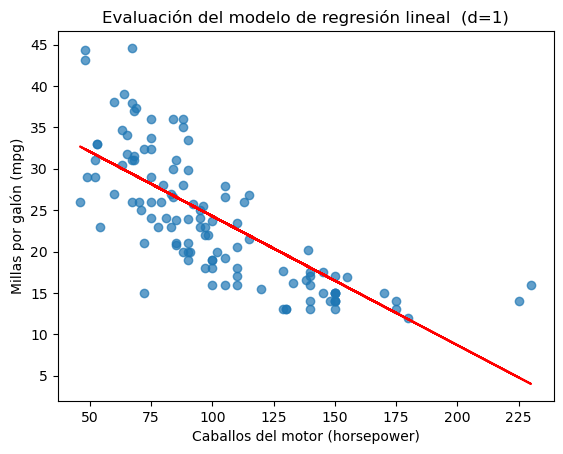

In [34]:
# Visualizamos en la muestra de testeo, la predicción de regresión lineal con un scatter plot
plt.plot(x_test, y_test, 'o', alpha=0.7)
plt.plot(x_test, y_pred_lreg, color="red")
plt.xlabel('Caballos del motor (horsepower)')
plt.ylabel('Millas por galón (mpg)')
plt.title('Evaluación del modelo de regresión lineal  (d=1)')

#### Regresiónes Polinómicas
Implican una transformación polinómica de las $X$, para luego implementar la regresión por MCO (Mínimos Cuadrados Ordinarios).

In [36]:
# Veamos un modelo cuadrático:
poly = PolynomialFeatures(degree = 2, include_bias=False) 
# Recordar setear include_bias=False dado que en la regresión lineal -con LinearRegression- se incluirá la  
#  constante (esto suma una columna de 1s)

# Transformamos el vector columna en una matriz para tener en cuenta el grado del polinomio de interés
print('X antes de la transformación:\n', x_train[:5,])
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.fit_transform(x_test)  
np.set_printoptions(suppress = True) # evita que el print salga con notación científica
print('X luego de la transformación:\n', x_train_poly[:5,])


X antes de la transformación:
 [[110]
 [110]
 [120]
 [170]
 [ 74]]
X luego de la transformación:
 [[  110. 12100.]
 [  110. 12100.]
 [  120. 14400.]
 [  170. 28900.]
 [   74.  5476.]]


In [38]:
# Ajustamos el modelo
model = LinearRegression().fit(x_train_poly, y_train) 
print('\nIntercepto:', model.intercept_)
print('Coeficientes:', model.coef_)



Intercepto: 58.88637083420218
Coeficientes: [-0.49542658  0.0013281 ]


In [40]:
# Calculamos el Error Cuadrático Medio
y_pred_poly = model.predict(x_test_poly)
ecm2 = mean_squared_error(y_test, y_pred_poly)
print('Error cuadrático medio (test):', ecm2)

Error cuadrático medio (test): 22.77066466411955


In [ ]:
# tarea para la casa: R2 y MSE testeo y train

[[46.        ]
 [49.75510204]
 [53.51020408]
 [57.26530612]
 [61.02040816]]
[[  46.         2116.        ]
 [  49.75510204 2475.57017909]
 [  53.51020408 2863.34194086]
 [  57.26530612 3279.3152853 ]
 [  61.02040816 3723.49021241]]


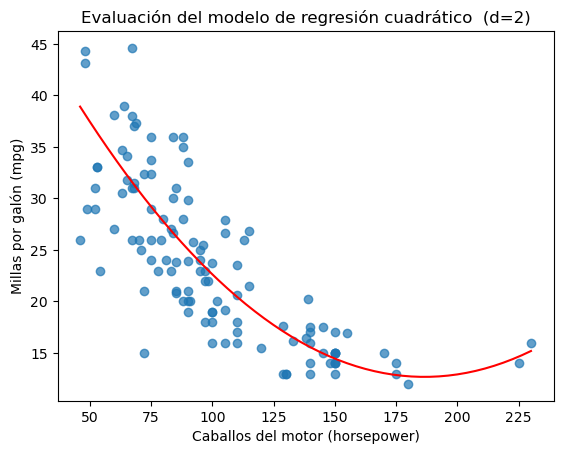

In [42]:
# Creamos un nuevo vector de X y aplicamos las transformaciones
X_seq = np.linspace(x_test.min(), x_test.max()).reshape(-1,1) 
print(X_seq[:5,])
# Valores entre el minimo y el maximo de X. 
# linspace por default crea 50 valores
# Aplicamos las transformaciones polinomicas
X_seq_poly = poly.fit_transform(X_seq) 
print(X_seq_poly[:5,])

# Gráfico en la base de entrenamiento para selecciónar el modelo (Model Selection)
plt.figure()
plt.scatter(x_test, y_test, alpha=0.7)
plt.plot(X_seq, model.predict(X_seq_poly),color="red")
plt.xlabel('Caballos del motor (horsepower)')
plt.ylabel('Millas por galón (mpg)')
plt.title("Evaluación del modelo de regresión cuadrático  (d=2)")
plt.show()

In [44]:
# Veamos un modelo cúbico:
poly = PolynomialFeatures(degree = 3, include_bias=False) 

x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.fit_transform(x_test)  
  
model = LinearRegression().fit(x_train_poly, y_train) 
y_pred_poly = model.predict(x_test_poly)

ecm3 = mean_squared_error(y_test, y_pred_poly)

print('\nIntercepto:', model.intercept_)
print('Coeficientes:', model.coef_)
print('Error cuadrático medio (test):', ecm3)


Intercepto: 71.71205803693745
Coeficientes: [-0.83726019  0.00412162 -0.00000703]
Error cuadrático medio (test): 24.319258896410123


A priori, viendo el ECM, parecería que la regresión polinomial de grado 2 es la que mejor funciona 

[[46.        ]
 [49.75510204]
 [53.51020408]
 [57.26530612]
 [61.02040816]]
[[    46.           2116.          97336.        ]
 [    49.75510204   2475.57017909 123172.24686993]
 [    53.51020408   2863.34194086 153218.01161081]
 [    57.26530612   3279.3152853  187790.9936846 ]
 [    61.02040816   3723.49021241 227208.89255327]]


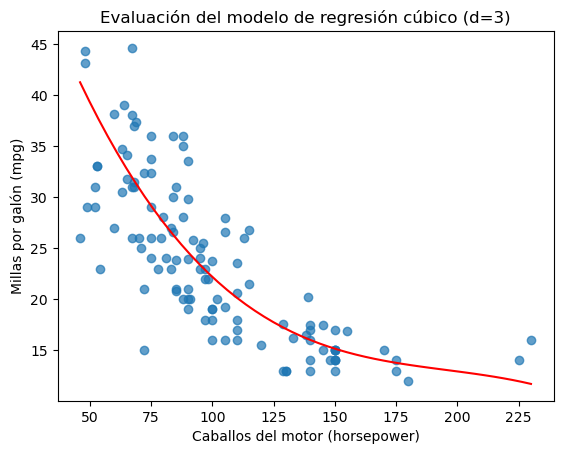

In [46]:
# Creamos un nuevo vector de X y aplicamos las transformaciones
X_seq = np.linspace(x_test.min(), x_test.max()).reshape(-1,1) 
print(X_seq[:5,])
# Valores entre el minimo y el maximo de X. 
# linspace por default crea 50 valores
# Aplicamos las transformaciones polinomicas
X_seq_poly = poly.fit_transform(X_seq) 
print(X_seq_poly[:5,])

# Gráfico en la base de entrenamiento para selecciónar el modelo (Model Selection)
plt.figure()
plt.scatter(x_test, y_test, alpha=0.7)
plt.plot(X_seq, model.predict(X_seq_poly),color="red")
plt.xlabel('Caballos del motor (horsepower)')
plt.ylabel('Millas por galón (mpg)')
plt.title("Evaluación del modelo de regresión cúbico (d=3)")
plt.show()

In [ ]:
#hacer este grafico de y_predic y y_train

### Enfoque de validación con una nueva participación
Ahora supongamos que cambiamos la muestra de entrenamienta y de testeo. Repetimos la selección y evaluación del modelo

In [48]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 50)

# Qué error esperarían que obtengamos esta vez?
poly = PolynomialFeatures(degree = 2, include_bias=False) 

x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.fit_transform(x_test)  
  
model = LinearRegression().fit(x_train_poly, y_train) 
y_pred_poly = model.predict(x_test_poly)

ecm3b = mean_squared_error(y_test, y_pred_poly)

print('\nIntercepto:', model.intercept_)
print('Coeficientes:', model.coef_)
print('Error cuadrático medio (test):', ecm3b)


Intercepto: 56.93289017601295
Coeficientes: [-0.45841107  0.00118358]
Error cuadrático medio (test): 15.358487806933876


##### Funciones: DocString, repaso
Cómo podemos repetir el código sin escribirlo por tercera vez?

Podemos hacer que nuestro código funcione para otros grados?

In [50]:
def transf_reg_poly(grado, x_train, x_test, y_train, y_test):
    '''
    La función realiza una transformación polinomial y luego corre una regresión lineal polinómica
    Input:
        grado
        x_train, x_test, y_train, y_test
    Output:
        modelo, ecm
    '''
    poly = PolynomialFeatures(degree = grado, include_bias=False) 

    x_train_poly = poly.fit_transform(x_train)
    x_test_poly = poly.fit_transform(x_test)  
  
    model = LinearRegression().fit(x_train_poly, y_train) 
    y_pred_poly = model.predict(x_test_poly)
    
    ecm = mean_squared_error(y_test, y_pred_poly)
    return model, ecm


In [52]:
ecm1 = transf_reg_poly(1, x_train, x_test, y_train, y_test)[1]
ecm2b = transf_reg_poly(2, x_train, x_test, y_train, y_test)[1]
ecm3b = transf_reg_poly(3, x_train, x_test, y_train, y_test)[1]
ecm4b = transf_reg_poly(4, x_train, x_test, y_train, y_test)[1]
ecm5b = transf_reg_poly(5, x_train, x_test, y_train, y_test)[1]

In [54]:
# Performance con la PRIMERA partición de muestras de entrenamiento y testeo
print('Regresión lineal:', ecm_lreg)
print('Grado2:', ecm2)
print('Grado3:', ecm3)

Regresión lineal: 26.658184066910614
Grado2: 22.77066466411955
Grado3: 24.319258896410123


In [56]:
# Performance con la SEGUNDA partición de muestras de entrenamiento y testeo
print('\nRegresión lineal:', ecm1)
print('Grado2:', ecm2b)
print('Grado3:', ecm3b)
print('Grado4:', ecm4b)
print('Grado5:', ecm5b)


Regresión lineal: 21.372690058743164
Grado2: 15.358487806933876
Grado3: 15.293069776610132
Grado4: 15.327734379917151
Grado5: 14.653573182123274


Podemos concluir que:
- la regresión lineal funciona peor (en ambos casos tiene mayor ECM)
- introducir un término cuadrático reduce el ECM en ambas muestras.

Pero en el caso de introducir un término cúbico, no es obvio si funciona mejor o no...

El ECM puede **variar** según qué observaciones quedaron incluidas en los sets de train y test

###  2. K-FOLD CROSS-VALIDATION  

Es un **técnica de remuestreo**. Se usa para estimar el error (test) asociado a un método de aprendizaje, para:  
- Elegir el nivel de complejidad optimo (Model selection)
- Evaluar el error de pronóstico fuera de la muestra (futura, condicional, contra fáctica, etc.) (Model Assesment)

Consiste en:
- Dividir las observaciones en k folds (pliegues), del mismo tamaño, aleatoriamente. 
- Ajustar el modelo k veces, cada vez con k-1 folds (distintos cada vez). Computar k veces el error de predicción en el fold reservado. (cada fold se usa k-1 veces como training set y 1 vez como test set).
- Estimar el error de predicción, estimación que surge de promediar las K estimaciones obtenidas.

Vamos a usar [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) de Scikitlearn

In [58]:
from IPython.display import Image, display

#Ilustración de Cross-Validation
display(Image(url="https://global.discourse-cdn.com/dlai/optimized/3X/a/3/a3ed2de61c2b4fa00f1b7e939753e1a7e181afb0_2_690x476.png"
))

In [60]:
y = auto['mpg']
X = auto['horsepower']
X = np.array(X).reshape((-1, 1))

from sklearn.model_selection import KFold

ecms = pd.DataFrame(columns=["grado", "particion", "ecm"])
ecms

,grado,particion,ecm


Lo usual es usar K=5 o K=10

In [64]:
print(type(X), type(y))
print(X.shape, y.shape)
#print(X.flatten(), y)

<class 'numpy.ndarray'> <class 'pandas.core.series.Series'>
(392, 1) (392,)


In [66]:
K = 10

for grado in range(2, 10):   

    kf = KFold(n_splits=K, shuffle=True, random_state=100)
    
    # El método kf.split aplicado a X nos da los conjuntos de índices que necesitamos para
    # partir nuestros conjunto de datos en training y testing en cada iteración.
    #  OXXXX
    #  XOXXX
    #  XXOXX
    #  XXXOX
    #  XXXXO
    
    for i, (train_index, val_index) in enumerate(kf.split(X)):   
        x_train, x_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        #print(i, x_train.shape[0])
        
        ecm = transf_reg_poly(grado, x_train, x_val, y_train, y_val)[1]
            
        df_i = pd.DataFrame({"grado": grado, "particion": i, "ecm": ecm}, index=[0])
        ecms = pd.concat([ecms, df_i])
    
ecms = ecms.astype({"grado":int, "particion":int})
ecms

/var/folders/s3/z1fnt3zs2nqd6lpnmt4yj7kh0000gn/T/ipykernel_3009/1660945322.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train, y_val = y[train_index], y[val_index]
/var/folders/s3/z1fnt3zs2nqd6lpnmt4yj7kh0000gn/T/ipykernel_3009/1660945322.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ecms = pd.concat([ecms, df_i])
/var/folders/s3/z1fnt3zs2nqd6lpnmt4yj7kh0000gn/T/ipykernel_3009/1660945322.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (con

,grado,particion,ecm
0,2,0,16.16
0,2,1,18.19
0,2,2,29.59
0,2,3,16.56
0,2,4,21.47
...,...,...,...
0,9,5,25.61
0,9,6,21.96
0,9,7,14.49
0,9,8,10.02


Una corrección para no contaminar los datos...

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 50)
print(type(X_train), type(y_train))
print(X_train.shape, y_train.shape)
#print(X_train, y_train)

<class 'numpy.ndarray'> <class 'pandas.core.series.Series'>
(274, 1) (274,)


In [70]:
ecms = pd.DataFrame(columns=["grado", "particion", "ecm"])
ecms

K = 10

for grado in range(1, 10):   

    kf = KFold(n_splits=K, shuffle=True, random_state=100)
    
    # El método kf.split aplicado a X nos da los conjuntos de índices que necesitamos para
    # partir nuestros conjunto de datos en training y testing en cada iteración.
    #  OXXXX
    #  XOXXX
    #  XXOXX
    #  XXXOX
    #  XXXXO
    
    for i, (train_index2, val_index2) in enumerate(kf.split(X_train)):
        X_train_fold, X_val_fold = X_train[train_index2], X_train[val_index2]
        y_train_fold, y_val_fold = y_train.iloc[train_index2], y_train.iloc[val_index2]
        #print(i, X_train_fold.shape[0])
        
        ecm = transf_reg_poly(grado, X_train_fold, X_val_fold, y_train_fold, y_val_fold)[1]
            
        df_i = pd.DataFrame({"grado": grado, "particion": i, "ecm": ecm}, index=[0])
        ecms = pd.concat([ecms, df_i])
    
ecms = ecms.astype({"grado":int, "particion":int})
ecms

/var/folders/s3/z1fnt3zs2nqd6lpnmt4yj7kh0000gn/T/ipykernel_3009/3356425881.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ecms = pd.concat([ecms, df_i])


,grado,particion,ecm
0,1,0,15.58
0,1,1,33.88
0,1,2,21.07
0,1,3,17.83
0,1,4,16.03
...,...,...,...
0,9,5,21.25
0,9,6,34.73
0,9,7,11.51
0,9,8,22.87


#### Cómo elegir el modelo?

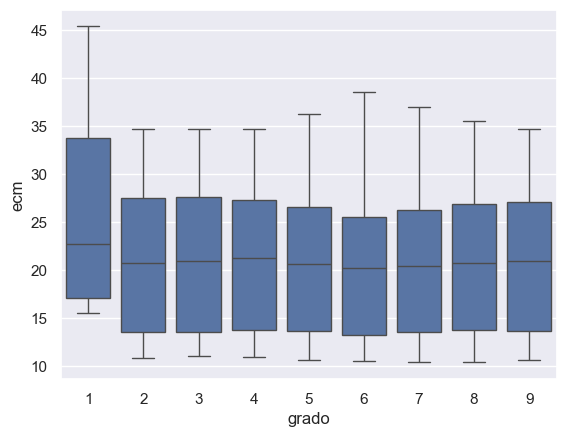

In [72]:
# Una opción: visualizar los ECMs en un boxplot
import seaborn as sns
sns.set()
ss = sns.boxplot(data=ecms, x="grado", y="ecm")


In [74]:
ecms.describe()

,grado,particion,ecm
count,90.00,90.00,90.00
mean,5.00,4.50,21.62
std,2.60,2.89,8.42
min,1.00,0.00,10.40
25%,3.00,2.00,12.44
50%,5.00,4.50,20.69
75%,7.00,7.00,28.79
max,9.00,9.00,45.42


In [76]:
# Una opción para ver el mejor modelo sería sacar el error promedio para cada grado:
ecms_avg = ecms.groupby('grado').agg({'ecm':'mean'})
ecms_avg.reset_index(inplace = True)
ecms_avg.astype({"grado":int})
ecms_avg

,grado,ecm
0,1,25.87
1,2,20.96
2,3,21.06
3,4,21.13
4,5,21.07
5,6,21.18
6,7,21.09
7,8,21.09
8,9,21.09


In [78]:
# Tarea para la casa: hacer grafico de puntos conectados como el libro (slide 25 panel de la izquierda-clase13)

In [80]:
# Función para seleccionar 
min_ecm = np.Inf
grado = None

for index, row in ecms_avg.iterrows():
    if row['ecm'] < min_ecm:
        min_ecm = row['ecm']
        grado = row['grado'].astype(int)

print('El mínimo error es', round(min_ecm, 2), 'y se da con un polinomio de grado', grado)

El mínimo error es 20.96 y se da con un polinomio de grado 2


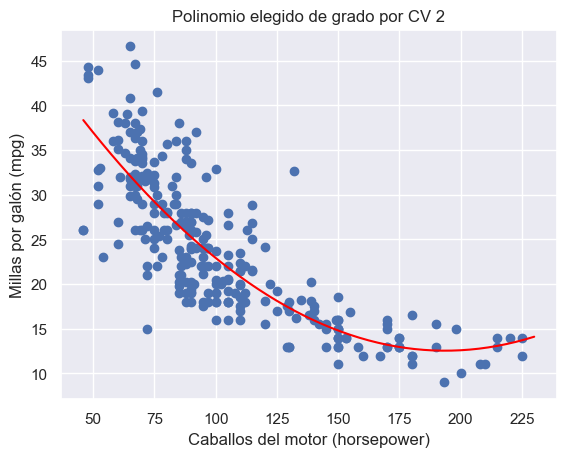

15.358487806933876

In [82]:
# Finalmente construimos el modelo polinomial de grado 2 y lo graficamos 
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 50)

modelo = transf_reg_poly(grado, x_train, x_test, y_train, y_test)[0]
ecm = transf_reg_poly(grado, x_train, x_test, y_train, y_test)[1]
        
X_seq = np.linspace(X.min(), X.max()).reshape(-1,1)
poly = PolynomialFeatures(degree = grado, include_bias=False) 
X_seq_poly = poly.fit_transform(X_seq)  

x_test_poly = poly.fit_transform(x_test)  
y_pred_poly = modelo.predict(x_test_poly)
ecm_final = mean_squared_error(y_test, y_pred_poly)

plt.figure()
plt.scatter(x_train, y_train)
plt.plot(X_seq, modelo.predict(X_seq_poly),color="red")
plt.xlabel('Caballos del motor (horsepower)')
plt.ylabel('Millas por galón (mpg)')
plt.title("Polinomio elegido de grado por CV {}".format(grado))
plt.show()

ecm_final